# Analysis of Tarantula surface brightness fluctuations

In [28]:
from pathlib import Path
import numpy as np
from astropy.io import fits
import astropy.units as u
from matplotlib import pyplot as plt
import turbustat.statistics as tss

Load moment data for Ha line.

In [3]:
fitsfilename = {
    "ha": "GAUS_Ha6562.8_060_Will.fits",
    "nii": "GAUS_NII6583.45_060_Will.fits",
}
datadir = Path("data/Tarantula/MUSE_R136toWill")
hdulist = fits.open(datadir / fitsfilename["ha"])
hdulist.info()


Filename: data/Tarantula/MUSE_R136toWill/GAUS_Ha6562.8_060_Will.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1158   ()      
  1  DATA          1 ImageHDU        52   (650, 650)   float64   
  2  DATA          1 ImageHDU        52   (650, 650)   float64   
  3  DATA          1 ImageHDU        52   (650, 650)   float64   


In [4]:
sb = hdulist[1].data

## PDF and spatial power spectrum

### Find PDF of Hα surface brightness

Normalize the surface brightness map by its mean. 

In [5]:
hdulist[1].data /= np.nanmean(hdulist[1].data)

First, we try the unweighted PDF.

In [6]:
pdf_mom0 = tss.PDF(hdulist[1], min_val=0.0, bins=None)

Optimization terminated successfully.
         Current function value: 1.195669
         Iterations: 19
         Function evaluations: 39
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -4.3410e+05
Model:                     Likelihood   AIC:                         8.682e+05
Method:            Maximum Likelihood   BIC:                         8.682e+05
Date:                Mon, 19 Apr 2021                                         
Time:                        14:12:43                                         
No. Observations:              363059                                         
Df Residuals:                  363057                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

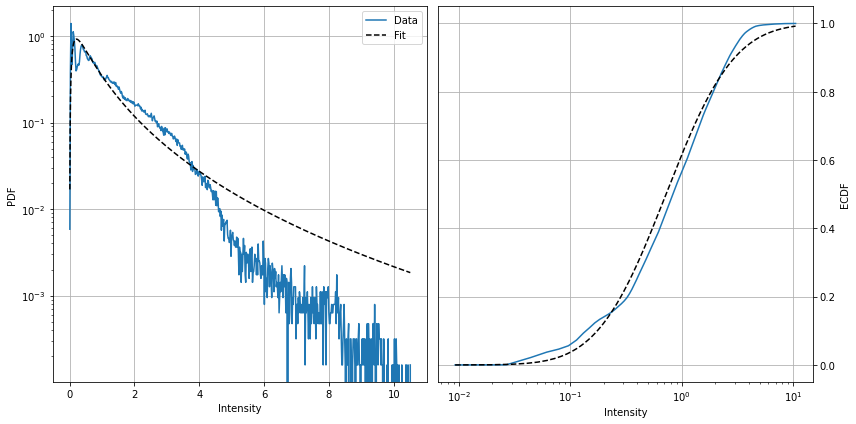

In [7]:
plt.figure(figsize=(12, 6))
pdf_mom0.run(verbose=True)

Despite the appearances, this is a log-normal PDF (dashed line) that is fitted to the observations (blue solid line). The reason that it looks a bit strange in the left-hand plot is that they are using uniform bin sizes on a linear scale. This gives a $x^{-1}$ term in the PDF of $x$, which skews the sistribution to the left.  Also they are plotting it on a linear scale in $x$, but a logarithmic scale in the PDF ($y$-axis).  This is probably because star-formation people are most interested in the high-density end of the PDF, which is what this emphasizes. 

The cumulatitive distribution function plot (right hand panel) is better suited to our purposes. Looking at the fit, it is clearly not optimised to the peak of the PDF (CDF of 0.5).  We could do a better "fit" to this part by using the median and the inter-quartile range to uniquely determine the $\mu$ and $\sigma$, respectively, of the log-normal. This would move the $\mu$ slightly to the right and possibly reduce the $\sigma$ slightly.

Anyway, using the fitted PDF, the peak is at 0.72 and the $\sigma$ is 1.1. 

Now I look at the scipy.stats implementation of the log-normal PDF.  The docs are very confusing, but I think I have sorted it out.

In [8]:
import seaborn as sns
sns.set_color_codes()
sns.set_context("talk")

In [9]:
from scipy.stats import lognorm

In [10]:
LN = lognorm(s=1.0, scale=np.exp(1.0))

[None]

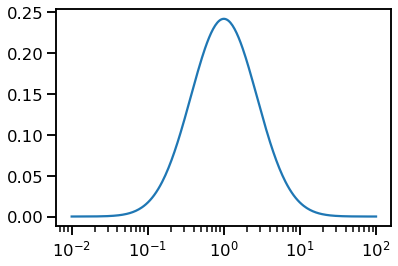

In [11]:
x = np.logspace(-2.0, 2.0, 300)
fig, ax = plt.subplots()
ax.plot(x, LN.pdf(x))
ax.set(xscale="log")

Now I replot the PDF myself, using the empirical PDF and the model fit that turbustat has fuond.

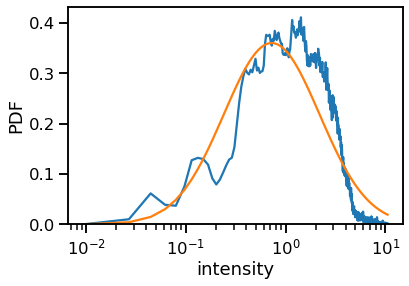

In [12]:
fig, ax = plt.subplots()
s, scale = pdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = pdf_mom0.bins
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [13]:
pdf_mom0.model_params

array([1.10657728, 0.7228587 ])

I have multiplied the PDF by $x$ to put it in the form per uniform logarithmic interval.  This is the only way that it actually looks like a Gaussian. 

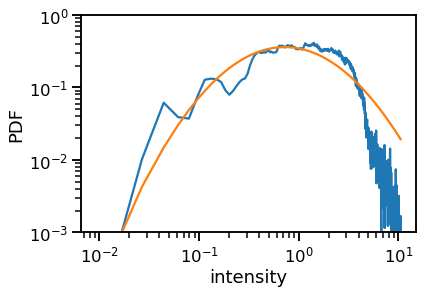

In [15]:
fig, ax = plt.subplots()
ax.plot(x, x*pdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    yscale="log",
    ylim=[1e-3, 1.0],
);

Then I plot the same thing on a log-log scale.  When you compare this with molecular hydrogen column density PDFs, such as in Dib:2020m, it doesn't look very impressive.  They have an excellent fit to a log-normal PDF on the low side, down to about 1e-5 in the histogram, whereas we have a much worse fit. 

#### Weighted PDF using turbustats

Next, we fit the weighted PDF, using the brightness itself as weight.  So the result is no longer the fraction of the POS area that has each intensity.  But instead is the fraction of the total flux that has that intensity.

Optimization terminated successfully.
         Current function value: 1.564274
         Iterations: 20
         Function evaluations: 41
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -5.6792e+05
Model:                     Likelihood   AIC:                         1.136e+06
Method:            Maximum Likelihood   BIC:                         1.136e+06
Date:                Mon, 19 Apr 2021                                         
Time:                        08:35:21                                         
No. Observations:              363059                                         
Df Residuals:                  363057                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

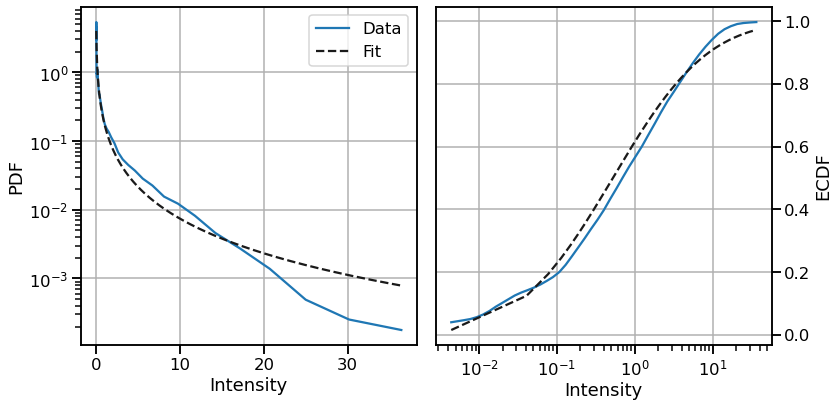

In [61]:
wpdf_mom0 = tss.PDF(hdulist[1], min_val=0.0, bins=np.logspace(-2.4, 1.6, 50), weights=hdulist[1].data)
plt.figure(figsize=(12, 6))
wpdf_mom0.run(verbose=True)

And plot the weighted pdf on a log scale as above:

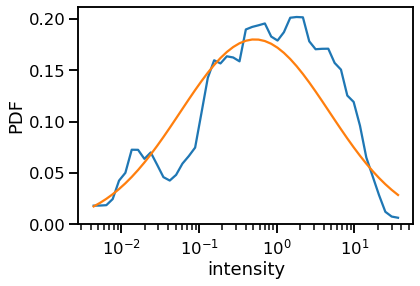

In [65]:
fig, ax = plt.subplots()
s, scale = wpdf_mom0.model_params
LN = lognorm(s=s, scale=scale)
x = wpdf_mom0.bins
ax.plot(x, x*wpdf_mom0.pdf)
ax.plot(x, x*LN.pdf(x))
ax.set(
    xlabel="intensity",
    ylabel="PDF",
    xscale="log",
    ylim=[0, None],
);

In [66]:
wpdf_mom0.model_params

array([2.21315457, 0.52252471])

This is a suprising appearance for the weighted version.  It has a larger width than the unweighted one.  **I don't understand what turbustats means by weighted in this context, so we can't rely on this**

#### Calculate the PDF by other means

First, look at the weighted PDF using seaborn:

<AxesSubplot:ylabel='Count'>

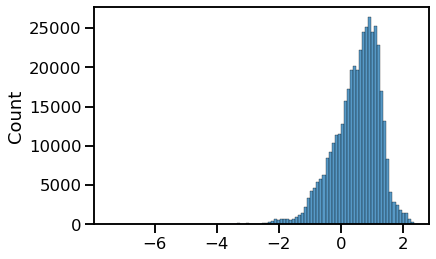

In [67]:
m = np.isfinite(sb) & (sb > 0.0)
sns.histplot(x=np.log(sb[m]), kde=False, weights=sb[m].astype(float), bins=100)

So that is very different from the turbustats version, and looks more convincing. Now, we check this by doing the same thing by hand with `np.histogram`:

In [70]:
H, edges = np.histogram(np.log(sb[m]), weights=sb[m], bins=100, range=[-4.0, 2.5], density=True)

[Text(0.5, 0, '$\\ln (S/S_0)$'), Text(0, 0.5, 'PDF')]

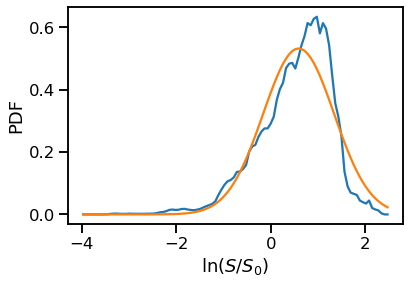

In [71]:
fig, ax = plt.subplots()
centers = 0.5*(edges[:-1] + edges[1:])
ax.plot(centers, H)
LN = lognorm(s=0.75,scale=1.8)
ax.plot(centers, np.exp(centers)*LN.pdf(np.exp(centers)))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="PDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)


That is exactly the same as the seaborn version, and makes perfect sense: the distribution is pulled up at the high brightness because of the brightness weighting.  Note that the log-normal fit is by eye.  

Now we look at the CDF:

[Text(0.5, 0, '$\\ln (S/S_0)$'), Text(0, 0.5, 'CDF')]

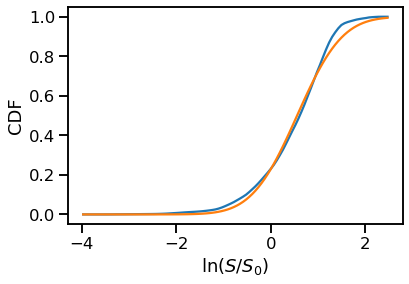

In [72]:
cdf = np.cumsum(H)*(centers[1] - centers[0])
fit = np.exp(centers)*LN.pdf(np.exp(centers))
cdf_fit = np.cumsum(fit)*(centers[1] - centers[0])

fig, ax = plt.subplots()
ax.plot(centers, cdf)
ax.plot(centers, cdf_fit)
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF",
#    yscale="log",
#    ylim=[1e-3, 1.0],
)

So that looks reasonable.  The log-normal fit is not very realistic, since it doesn't account for the skewness of the distribution.  The observed distribution has an excess at low brightness and a deficit at high brightness, as compared with the fit. 

[Text(0.5, 0, '$\\ln (S/S_0)$'),
 Text(0, 0.5, 'CDF / (1 $-$ CDF)'),
 None,
 (0.0003333333333333333, 3000.0)]

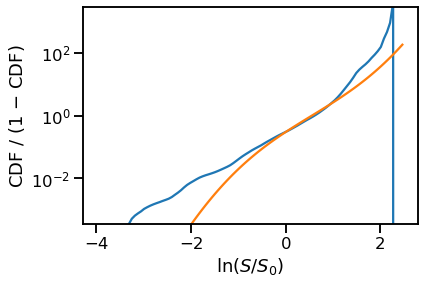

In [78]:
fig, ax = plt.subplots()
ax.plot(centers, cdf/(1 - cdf))
ax.plot(centers, cdf_fit/(1 - cdf_fit))
ax.set(
    xlabel="$\ln (S/S_0)$",
    ylabel="CDF / (1 $-$ CDF)",
    yscale="log",
    ylim=[1e-3/3, 3e3],
)

This is an experiment with plotting $\mathrm{CDF}/(1 - \mathrm{CDF})$ on a log scale, which gives better visibility to the low and high-intensity wings and emphasizes the disagreement with the log-normal model. We have to be careful with interpreting the CDF graphs, since the sense of a deviation flips when you go past the half-way point.  The blue line is above the orange line at high and low intensities, but this only indicates an excess at low intensities.  At high intensities it indicates a *deficit* (observations below model). 

#### Conclusions on the weighted PDF

The width of the PDF is $\sigma \approx 0.75$, which is 50% larger than we found in Orion. 

### Spatial power spectrum of Hα surface brightness

In [17]:
pspec = tss.PowerSpectrum(hdulist[1])

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     9012.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):          2.18e-303
Time:                        23:32:44   Log-Likelihood:                -95.652
No. Observations:                 460   AIC:                             195.3
Df Residuals:                     458   BIC:                             203.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9516      0.027     71.357      0.0

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


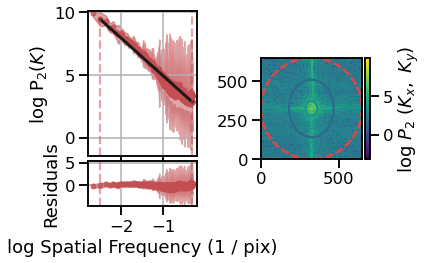

In [18]:
pspec.run(verbose=True)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


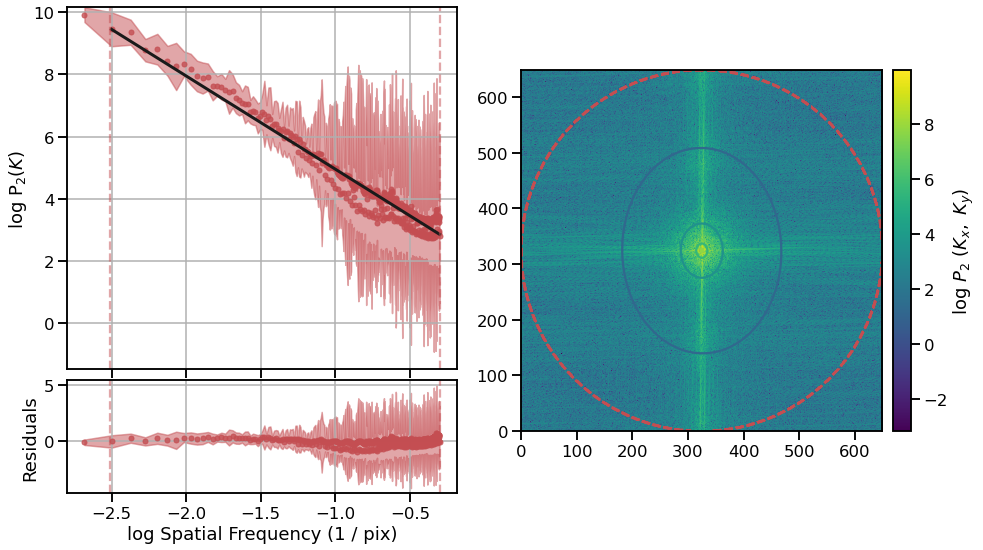

In [19]:
plt.figure(figsize=(14, 8))
pspec.plot_fit(show_2D=True)

[None, None]

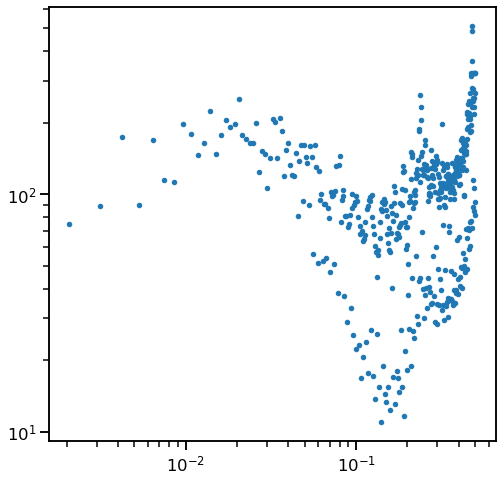

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(pspec.freqs, pspec.freqs**3 * pspec.ps1D, ".")
ax.set(
    xscale="log", yscale="log",
)

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4290.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):          2.04e-166
Time:                        23:32:48   Log-Likelihood:                 50.891
No. Observations:                 183   AIC:                            -93.78
Df Residuals:                     179   BIC:                            -80.94
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7880      0.221      8.084      0.0

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


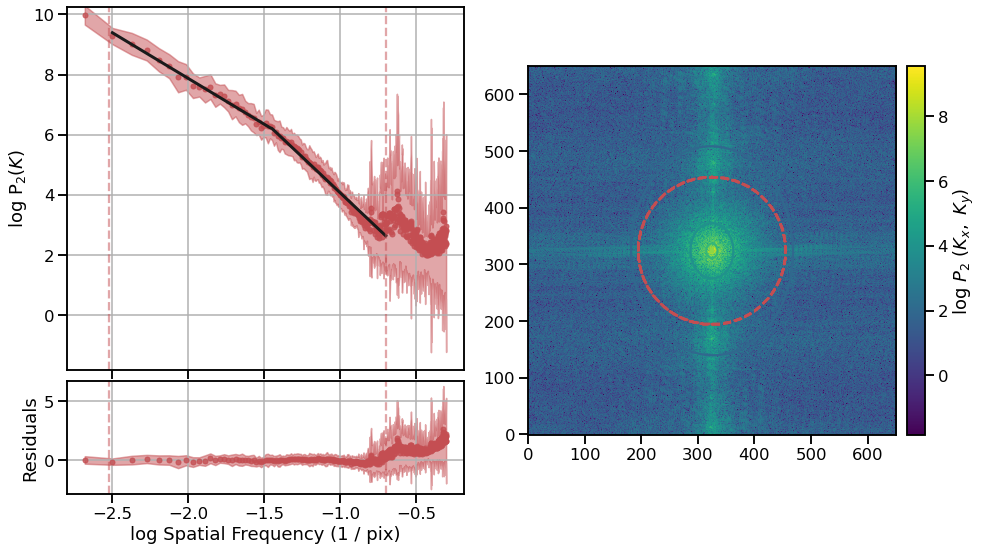

In [22]:
plt.figure(figsize=(14, 8))
pspec.run(
    verbose=True, 
    apodize_kernel="tukey", alpha=0.3,
    fit_2D=False, 
    low_cut=0.003/ u.pix,
    high_cut=0.2/ u.pix,
    fit_kwargs={"brk": 0.02 / u.pix, "log_break": False},
)

[None, None]

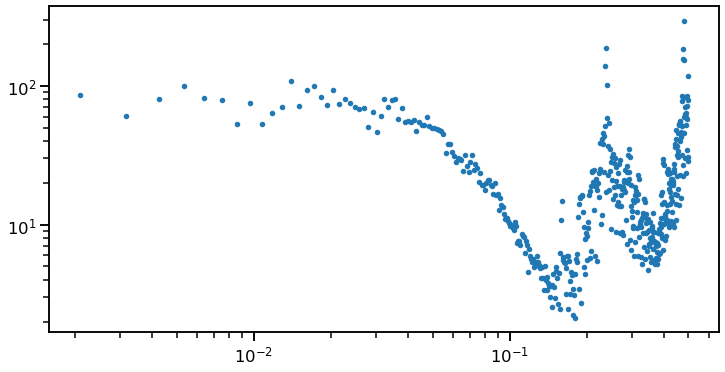

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pspec.freqs, pspec.freqs**3 * pspec.ps1D, ".")
ax.set(
    xscale="log", yscale="log",
)

In [24]:
pspec_v = tss.PowerSpectrum(hdulist[2])

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4393.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           1.18e-73
Time:                        23:32:50   Log-Likelihood:                 68.879
No. Observations:                  85   AIC:                            -133.8
Df Residuals:                      83   BIC:                            -128.9
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0903      0.073     28.695      0.0

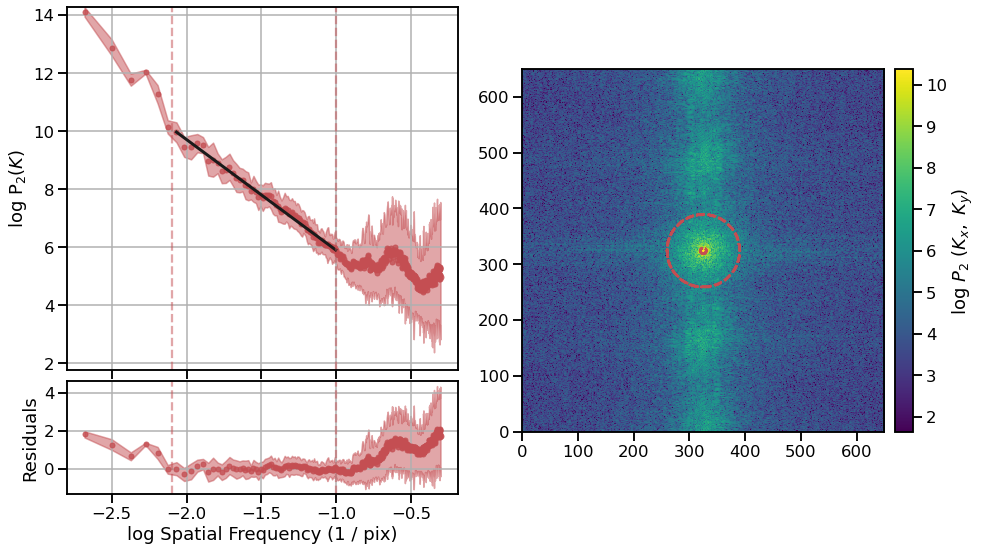

In [25]:
plt.figure(figsize=(14, 8))
pspec_v.run(
    verbose=True, 
    apodize_kernel="splitcosinebell", alpha=0.5, beta=0.2,
    fit_2D=False, 
    low_cut=0.008/ u.pix,
    high_cut=0.1/ u.pix,
    #fit_kwargs={"brk": 0.02 / u.pix, "log_break": False},
)

[None, None]

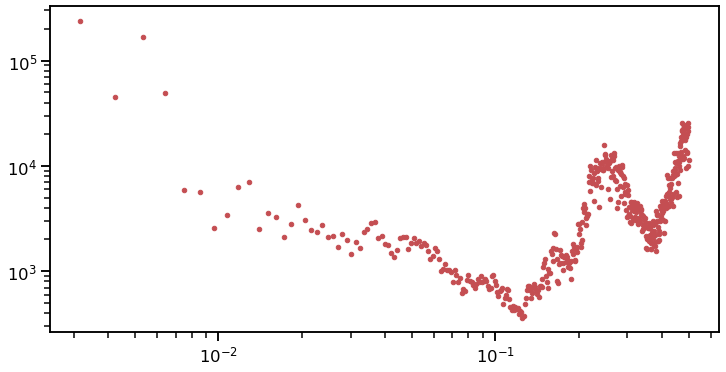

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
pspec_v.freqs[0] = np.nan
ax.plot(pspec_v.freqs, pspec_v.freqs**3 * pspec_v.ps1D, ".", color="r")
ax.set(
    xscale="log", yscale="log",
)

In [27]:
hdulist_n2 = fits.open(datadir / fitsfilename["nii"])

In [28]:
m = hdulist_n2[1].data > 6e4
hdulist_n2[1].data[m] = np.median(hdulist_n2[1].data)

In [29]:
pspec_n2 = tss.PowerSpectrum(hdulist_n2[1])

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4189.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):           1.86e-90
Time:                        23:32:53   Log-Likelihood:                 98.586
No. Observations:                  87   AIC:                            -189.2
Df Residuals:                      83   BIC:                            -179.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5894      0.129     81.937      0.0

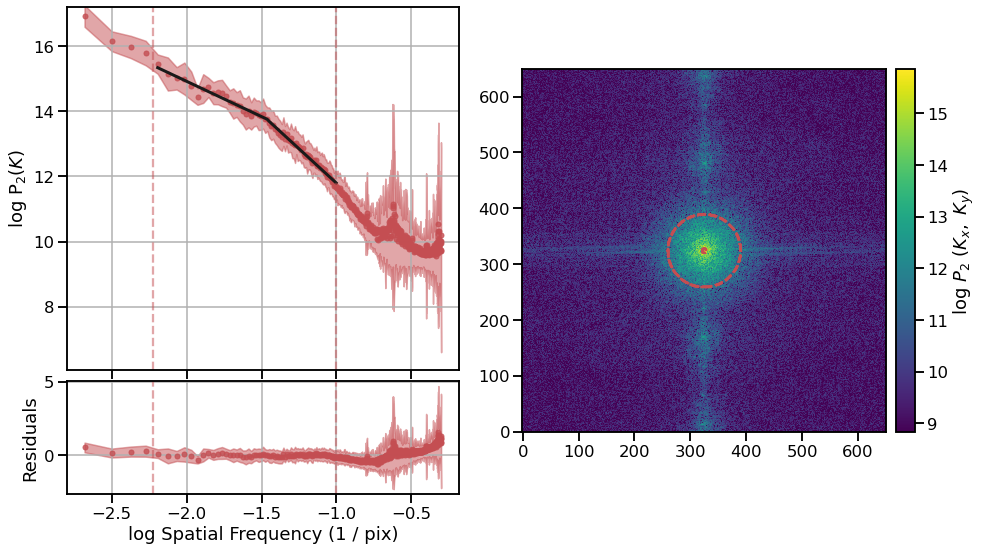

In [30]:
plt.figure(figsize=(14, 8))
pspec_n2.run(
    verbose=True, 
    apodize_kernel="tukey", alpha=0.3,
    fit_2D=False, 
    low_cut=0.006/ u.pix,
    high_cut=0.1/ u.pix,
    fit_kwargs={"brk": 0.02 / u.pix, "log_break": False},
)

[None, None]

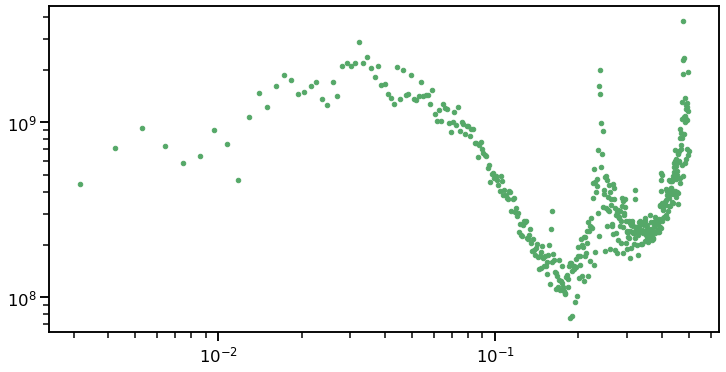

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
pspec_n2.freqs[0] = np.nan
ax.plot(pspec_n2.freqs, pspec_n2.freqs**3 * pspec_n2.ps1D, ".", color="g")
ax.set(
    xscale="log", yscale="log",
)

## Delta variance of the intensity and velocity maps

In principle, the delta variance is quite similar to the structure function in the sense that it is measuring the variance as a function of scale.  It is generally applied to column densities, but there is nothing stopping us applying it to the velocity field as well.  

Acording to the case stiudies in the turbustats documentation, it deals with edge effects in non-periodic data sets much better than the power law does.

In [16]:
dvar = tss.DeltaVariance(hdulist[1])

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/sta

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            WLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     146.5
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.81e-09
Time:                        12:40:18   Log-Likelihood:                 16.238
No. Observations:                  18   AIC:                            -28.48
Df Residuals:                      16   BIC:                            -26.70
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3685      0.084    -40.298      0.0

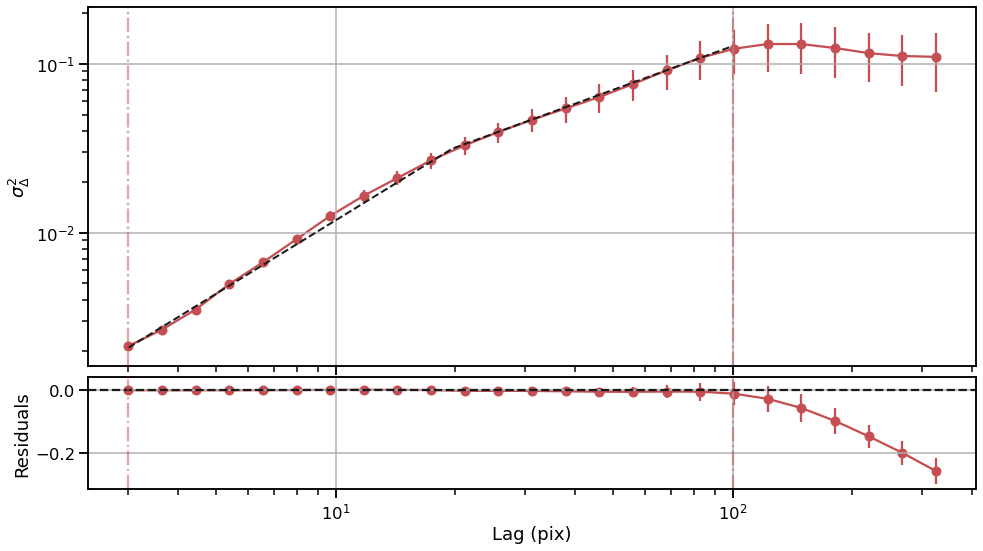

In [33]:
plt.figure(figsize=(14, 8))
dvar.run(verbose=True, boundary="fill", xlow=3*u.pix, xhigh=100*u.pix, brk=30*u.pix)

In [32]:
plt.figure(figsize=(14, 8))
dvar.plot_fit()

TypeError: plot_fit() got an unexpected keyword argument 'verbose'

<Figure size 1008x576 with 0 Axes>

This looks very similar to the structure function!

Now try it on the velocities.  We have to tidy up the data first, since it contains NaNs, which turbustat doesn't like. Replace all bad pixels with the median velocity:

In [23]:
vmed = np.nanmedian(hdulist[2].data)
m = np.isfinite(hdulist[2].data)
hdulist[2].data[~m] = vmed

In [24]:
dvar_v = tss.DeltaVariance(hdulist[2])

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/sta

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     360.5
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           2.17e-11
Time:                        12:37:31   Log-Likelihood:                 20.873
No. Observations:                  16   AIC:                            -37.75
Df Residuals:                      14   BIC:                            -36.20
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0803      0.066    -16.273      0.0

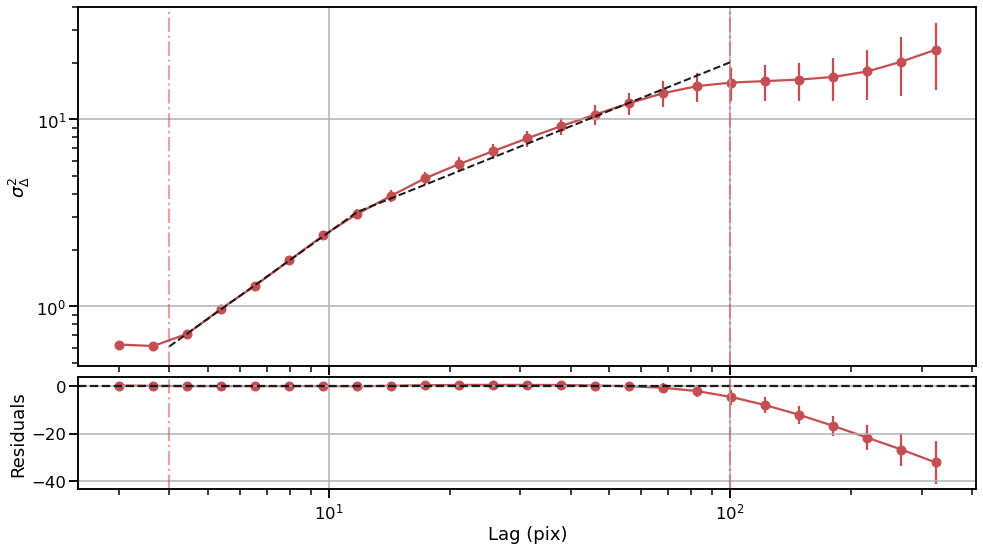

In [31]:
plt.figure(figsize=(14, 8))
dvar_v.run(verbose=True, boundary="fill", xlow=4*u.pix, xhigh=100*u.pix, brk=30*u.pix)

Now, we will try normalizing everything:

In [34]:
vmean = np.mean(hdulist[2].data)
vsig = np.std(hdulist[2].data)
print(vmean, vsig)
dv = (hdulist[2].data - vmean) / vsig

265.39783940220644 14.743971519215005


In [37]:
ln_S = np.log(hdulist[1].data)
ln_S[~np.isfinite(ln_S)] = np.nanmedian(ln_S)
ln_S_mean = np.mean(ln_S)
ln_S_sig = np.std(ln_S)
print(ln_S_mean, ln_S_sig)
dlnS = (ln_S - ln_S_mean)/ln_S_sig

-0.33561196698486306 1.0261513452720181


<ipython-input-37-ca14813e3551>:1: RuntimeWarning: divide by zero encountered in log
  ln_S = np.log(hdulist[1].data)


In [38]:
dvar_dlnS = tss.DeltaVariance(dlnS, header=hdulist[1].header)

In [39]:
dvar_dv = tss.DeltaVariance(dv, header=hdulist[2].header)

In [40]:
dvar_dlnS.compute_deltavar(boundary="fill")

In [42]:
dvar_dv.compute_deltavar(boundary="fill")

Compare the 

In [55]:
def bfunc(r, r0, sig2, m):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    return 2.0*sig2*(1 - C)


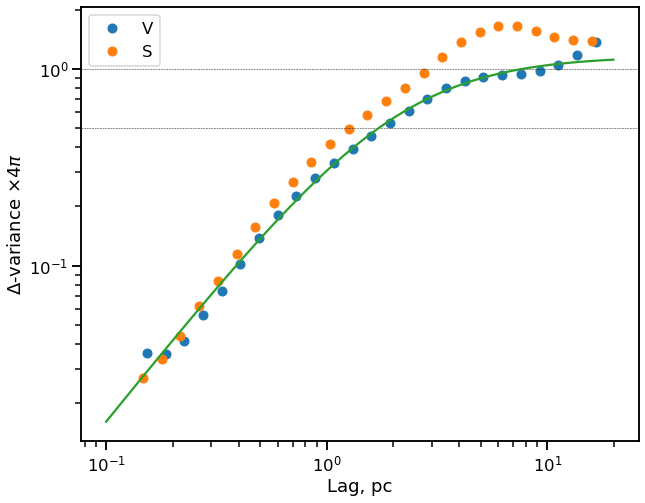

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
NORM = 4*np.pi
PIX = 0.05 # pixel scale in pc
#ax.plot(dvar_dlnS.lags, NORM*dvar_dlnS.delta_var, "o", label="ln S")
ax.plot(PIX*1.02*dvar_dv.lags, NORM*dvar_dv.delta_var, "o", label="V")
ax.plot(PIX*0.98*dvar.lags, NORM*dvar.delta_var, "o", label="S")
ax.axhline(1.0, lw=0.5, ls="--", color="k")
ax.axhline(0.5, lw=0.5, ls="--", color="k")

x = np.logspace(-1.0, 1.3, 200)
ax.plot(x, bfunc(x, r0=2.1, sig2=0.58, m=1.4))

ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="Lag, pc",
    ylabel=r"$\Delta$-variance $\times 4\pi$",
);

## Using generated red-noise to simulate two layers

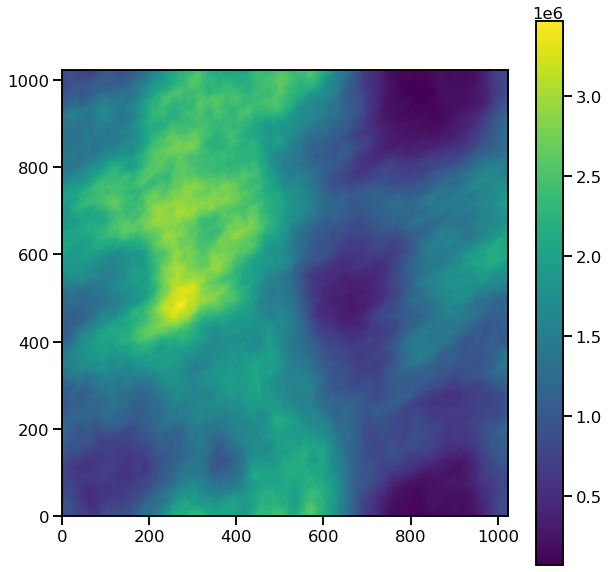

In [32]:
from turbustat.simulator import make_extended
img = make_extended(1024, powerlaw=4.0, ellip=0.5, theta=45, randomseed=3)
# Now shuffle so the peak is near the centre
#img = np.roll(img, (128, -30), (0, 1))
img -= img.min()
img2 = make_extended(1024, powerlaw=4.0, ellip=0.5, theta=135, randomseed=99)
img2 -= img2.min()
plt.figure(figsize=(10, 10))
plt.imshow(img**2 + img2**2, origin='lower')  
plt.colorbar()  

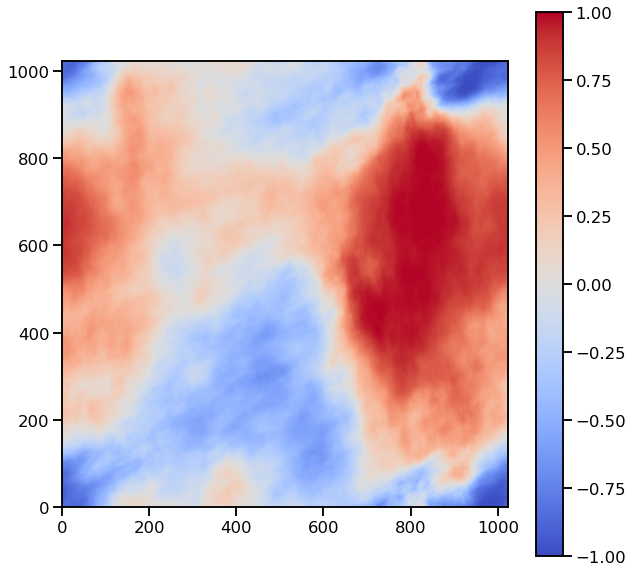

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow((img**2 - img2**2)/(img**2 + img2**2), origin='lower', cmap="coolwarm")  
plt.colorbar()  

Optimization terminated successfully.
         Current function value: 15.000907
         Iterations: 56
         Function evaluations: 127
                              Likelihood Results                              
Dep. Variable:                      y   Log-Likelihood:            -1.5730e+07
Model:                     Likelihood   AIC:                         3.146e+07
Method:            Maximum Likelihood   BIC:                         3.146e+07
Date:                Sun, 18 Apr 2021                                         
Time:                        23:33:19                                         
No. Observations:             1048576                                         
Df Residuals:                 1048574                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

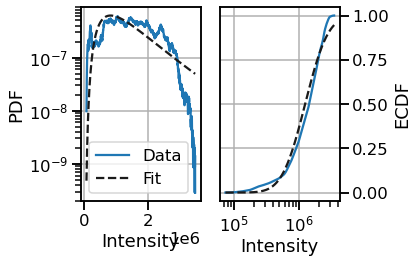

In [34]:
tss.PDF(fits.PrimaryHDU(img**2 + img2**2), min_val=0.0, bins=None).run(verbose=True)

## Is delta variance affected by projection smoothing?

Projection smoothing operates at scales smaller than the line-of-sight depth through a turbulent region and means that the 2D structure function slope becomes steeper than the 3D structure function slope.  So it becomes $\beta - 3$ instead of $\beta - 2$. Where $\beta$ is the slope of the power spectrum: $P(k) \propto k^{-\beta}$.  This is the notation of Ossenkopf:2006a. 

We want to check that his really produces a change in the slope of the structure function, and also to check whether we see anything similar in the delta-variance.  From what everyone says, the delta-variance should mot suffer from the same problem, but I am not sure I beleive it.  

Also, we can check the difference between steep and shallow spectra.  Ossenpof:2006a imply that it is only for shallow spectra that the autocorrelation function is a poer law.  

We can investigate this using the 3D fBM functions of turbustats.

In [67]:
from turbustat.simulator import make_3dfield

In [217]:
threeD_field = make_3dfield(128, powerlaw=2.5)

In [249]:
deep_vmap = np.mean(threeD_field, axis=0)
koffset = 64
shallow_vmap = np.mean(threeD_field[koffset:16 + koffset, :, :], axis=0)

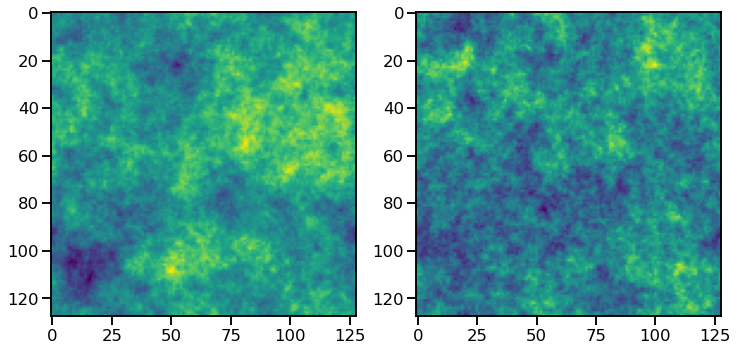

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(deep_vmap)
axes[1].imshow(shallow_vmap)

In [237]:
dvar_deep = tss.DeltaVariance(fits.PrimaryHDU(deep_vmap))

In [238]:
dvar_shallow = tss.DeltaVariance(fits.PrimaryHDU(shallow_vmap))

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5749.
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           4.18e-29
Time:                        11:07:09   Log-Likelihood:                 70.529
No. Observations:                  25   AIC:                            -137.1
Df Residuals:                      23   BIC:                            -134.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9649      0.006   -525.541      0.0

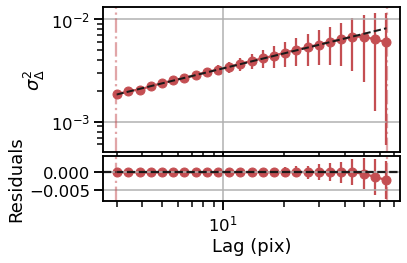

In [239]:
dvar_deep.run(verbose=True)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.725
Model:                            WLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     20.19
Date:                Thu, 22 Apr 2021   Prob (F-statistic):           0.000165
Time:                        11:07:21   Log-Likelihood:                 48.489
No. Observations:                  25   AIC:                            -92.98
Df Residuals:                      23   BIC:                            -90.54
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9189      0.026    -73.542      0.0

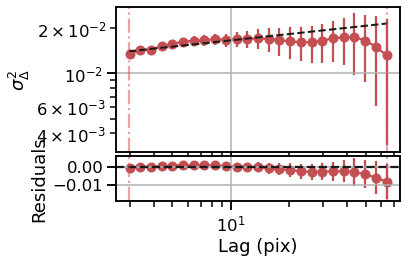

In [240]:
dvar_shallow.run(verbose=True)

In [241]:
deep_vmap.std()

0.26194809939399405

In [251]:
shallow_vmap.std()

0.5368822950490622

In [243]:
threeD_field[:, 0, 0].std()

1.072375919716731

In [252]:
deep_sig_los = threeD_field[:, :, :].std(axis=0)
shallow_sig_los = threeD_field[koffset:16 + koffset, :, :].std(axis=0)

In [253]:
deep_sig_los.mean(), deep_sig_los.std()

(0.9603253103113626, 0.09570000835558815)

In [254]:
shallow_sig_los.mean(), shallow_sig_los.std()

(0.8065880773170265, 0.1890485248102029)

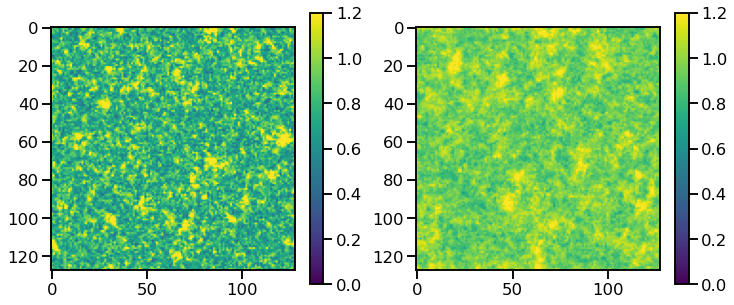

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
im0 = axes[0].imshow(shallow_sig_los, vmin=0.0, vmax=1.2)
c0 = fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(deep_sig_los, vmin=0.0, vmax=1.2)
c1 = fig.colorbar(im1, ax=axes[1])

So, this is interesting.  For the shallow velocity spectrum, $k=2$, the LOS sigma does not show much variation, either in the thick or the thin volume. 

Whereas, with the steep velocity spectrum, $k=4$, we see a broad PDF of the LOS sigma

**We need to sort out the terminology better.  We can use deep-vs-shallow for LOS thickness, or we can use steep-vs-shallow for power spectrum slope, but we shouldn't use shallow for both**

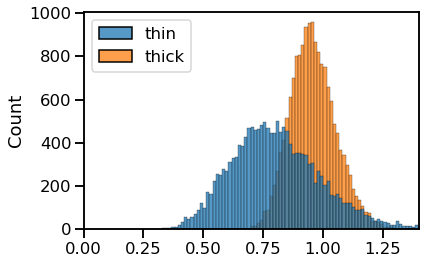

In [256]:
sns.histplot(
    {"thin": shallow_sig_los.ravel(), "thick": deep_sig_los.ravel()}
)
plt.gca().set(xlim=[0.0, 1.4]);

This is the histogram of the LOS sigmas, which for the shallow spectrum becomes narrow, with a mean of just less than 1, especially for the thick cloud.  

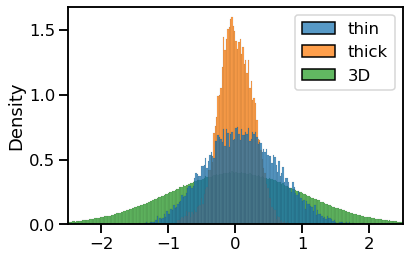

In [257]:
sns.histplot(
    {
        "thin": shallow_vmap.ravel(), 
        "thick": deep_vmap.ravel(), 
        "3D": threeD_field.ravel(),
    },
    stat="density",
    common_norm=False,
)
plt.gca().set(xlim=[-2.5, 2.5]);

And this is a histogram of the centroid velocities, compared with the 3D velocities in green.  For the shallow spectrum, the distribution is narrower than that of the full cube. 